
### 1. Read & clean up data

Datasets is open-source and were taken from https://huggingface.co/datasets/arkodeep/jobdata (english vacancies) and https://www.kaggle.com/datasets/vyacheslavpanteleev1/hhru-it-vacancies-from-20211025-to-20211202 (russian vacancies)


#### 1. Read

We do not need all the data in the tables, so will throw out some (most) of the columns. Also it is good idea to combine datasets


In [11]:
import pandas as pd

data_en = pd.read_csv('vacancies-skills_datasets/jobs_all.csv')
data_ru = pd.read_csv('vacancies-skills_datasets/IT_vacancies_full.csv')

In [12]:
data_en.columns

Index(['job_title_short', 'job_title', 'job_location', 'job_via',
       'job_schedule_type', 'job_work_from_home', 'search_location',
       'job_posted_date', 'job_no_degree_mention', 'job_health_insurance',
       'job_country', 'salary_rate', 'salary_year_avg', 'salary_hour_avg',
       'company_name', 'job_skills', 'job_type_skills', 'key_id'],
      dtype='object')

In [13]:
data_ru.columns

Index(['Ids', 'Employer', 'Name', 'Salary', 'From', 'To', 'Experience',
       'Schedule', 'Keys', 'Description', 'Area', 'Professional roles',
       'Specializations', 'Profarea names', 'Published at'],
      dtype='object')

In [14]:
data_en = data_en[['job_title','job_skills']]
data_ru = data_ru[['Name','Keys']]

In [15]:
data_en.head()

,job_title,job_skills
0,Senior Clinical Data Engineer / Principal Clin...,NaN
1,Data Analyst,"['r', 'python', 'sql', 'nosql', 'power bi', 't..."
2,"Data Engineer/Scientist/Analyst, Mid or Senior...","['python', 'sql', 'c#', 'azure', 'airflow', 'd..."
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"['python', 'c++', 'java', 'matlab', 'aws', 'te..."
4,Data Engineer- Sr Jobs,"['bash', 'python', 'oracle', 'aws', 'ansible',..."


In [16]:
data_ru.head()

,Name,Keys
0,Golang Developer (Кипр),"['Docker', 'Golang', 'Redis', 'Английский язык..."
1,Е-mail маркетолог,"['Грамотность', 'Написание текстов', 'Грамотна..."
2,Оператор call-центра (удаленно),"['Клиентоориентированность', 'Ориентация на ре..."
3,Ведущий SMM специалист,"['Продвижение бренда', 'Креативность', 'Adobe ..."
4,UX/UI Designer,"['UI', 'UX', 'gamedev', 'game design', 'проект..."


In [27]:
data_ru.rename(columns = {'Name': 'job_title', 'Keys': 'job_skills'}, inplace = True)

data_combined = pd.concat([data_en, data_ru], ignore_index=True)
data_combined.head()

,job_title,job_skills
0,Senior Clinical Data Engineer / Principal Clin...,NaN
1,Data Analyst,"['r', 'python', 'sql', 'nosql', 'power bi', 't..."
2,"Data Engineer/Scientist/Analyst, Mid or Senior...","['python', 'sql', 'c#', 'azure', 'airflow', 'd..."
3,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"['python', 'c++', 'java', 'matlab', 'aws', 'te..."
4,Data Engineer- Sr Jobs,"['bash', 'python', 'oracle', 'aws', 'ansible',..."



#### 2. Clean up text

Transfer everything to the lower register, remove Nans and excess punctiation, convert skills into arrays etc

In [28]:
import re
import ast

data_combined = data_combined.dropna()
data_combined['job_skills'] = data_combined['job_skills'].apply(ast.literal_eval)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[-/()]', ' ', text)
    text = re.sub(r'[^a-zA-Zа-яА-Я0-9+#+.]', ' ', text)
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_cell(cell):
    if isinstance(cell, list):
        return [clean_text(item) for item in cell if isinstance(item, str)]
    elif isinstance(cell, str):
        return clean_text(cell)
    else:
        return cell

for col in data_combined.columns:
    data_combined[col] = data_combined[col].apply(clean_cell)


In [35]:
data_combined.head(10)

,job_title,job_skills
1,data analyst,"[r, python, sql, nosql, power bi, tableau]"
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,..."
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k..."
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j..."
5,gcp data engineer,"[python, sql, gcp]"
6,senior data engineer gcp cloud,"[sql, python, java, sql server, gcp, bigquery,..."
7,data engineer,"[sql, nosql, gcp, azure, aws, bigquery, databr..."
8,technology operations business analyst,"[excel, powerpoint, power bi]"
9,data scientist ii,"[sql, python, r, mongodb, mongodb, sql server,..."
10,erfahrene r data engineer in m w d,"[python, databricks, azure, spark]"



### 3. Work with job titles
Plan is follows:
1. Remove stop-words
2. Start combining by using n-grams. They help to match patterns like 'pyhon developer' and 'developer python'
3. Create embeddings using sentence transformers or tf-idf
4. Apply clusterization to embeddings using dbscan or hdbscan or agglomerative clustering

#### 3.1 No stop words

In [30]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words_en = set(stopwords.words('english'))
stop_words_ru = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
def remove_stopwords(text):
    words = text.lower().split()
    filtered_words = [w for w in words if w not in stop_words_en and w not in stop_words_ru]
    return filtered_words

In [37]:
sentences = data_combined['job_title'].apply(remove_stopwords).tolist()

print(sentences[:10])
print(sentences[-10:])

[['data', 'analyst'], ['data', 'engineer', 'scientist', 'analyst', 'mid', 'senior', 'f', 'x'], ['lead', 'engineer', 'principal', 'analyst', 'principal', 'engineer', 'data...'], ['data', 'engineer', 'sr', 'jobs'], ['gcp', 'data', 'engineer'], ['senior', 'data', 'engineer', 'gcp', 'cloud'], ['data', 'engineer'], ['technology', 'operations', 'business', 'analyst'], ['data', 'scientist', 'ii'], ['erfahrene', 'r', 'data', 'engineer', 'w']]
[['администратор', 'баз', 'данных', 'database', 'administrator'], ['lead', 'data', 'scientist'], ['инженер', 'категории'], ['специалист', 'поддержки', 'приложений'], ['системный', 'аналитик', 'dwh'], ['монтажник', 'слаботочных', 'систем'], ['системный', 'администратор'], ['менеджер', 'работе', 'маркетплейсами', 'офис'], ['менеджер', 'продажам', 'серверное', 'оборудование', 'b2b'], ['product', 'analyst']]


#### 3.2 N-gramms

* gensim - not cool
* Scikit-learn CountVectorizer - applied
* RAKE / TextRank / YAKE (Unsupervised Keyword Extractors) - not tried

##### gensim

In [45]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [69]:
# create bi-gram model
bigram_model = Phrases(sentences, min_count=2, threshold=1)
# min_count=50 — ignore pairs that apper <= 50 times
# threshold=10 — less phrazes

bigram_model.add_vocab(sentences)


bigram_phraser = Phraser(bigram_model)  # to fasten up


In [70]:
data_combined['job_title_bigram'] = [bigram_phraser[sentence] for sentence in sentences]

print(len(bigram_phraser.phrasegrams))
print(list(bigram_phraser.phrasegrams)[:20])  # первые 20 биграмм


34384
['f_x', 'erfahrene_r', 'h_f', 'team_lead', 'veloppeur_euse', 'euse_big', 'f_h', 'phd_position', 'datalab_team', 'knowledge_graphs', 'work_home', 'home_eligible', 'full_time', 'time_part', 'part_time', 'royal_canin', 'binance_accelerator', 'accelerator_program', 'risk_management', 'bangkok_based']


In [71]:
data_combined.head(20)

,job_title,job_skills,job_title_bigram
1,data analyst,"[r, python, sql, nosql, power bi, tableau]","[data, analyst]"
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,...","[data, engineer, scientist, analyst, mid, seni..."
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k...","[lead, engineer, principal, analyst, principal..."
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j...","[data, engineer, sr, jobs]"
5,gcp data engineer,"[python, sql, gcp]","[gcp, data, engineer]"
6,senior data engineer gcp cloud,"[sql, python, java, sql server, gcp, bigquery,...","[senior, data, engineer, gcp, cloud]"
7,data engineer,"[sql, nosql, gcp, azure, aws, bigquery, databr...","[data, engineer]"
8,technology operations business analyst,"[excel, powerpoint, power bi]","[technology, operations, business, analyst]"
9,data scientist ii,"[sql, python, r, mongodb, mongodb, sql server,...","[data, scientist, ii]"
10,erfahrene r data engineer in m w d,"[python, databricks, azure, spark]","[erfahrene_r, data, engineer, w]"


##### count vectorizer

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2), min_df=3)

In [ ]:
texts = [' '.join(tokens) for tokens in sentences]
# text -> frequency matrix
X = vectorizer.fit_transform(texts)

# get bigrams and frequences
bigrams = vectorizer.get_feature_names_out()
counts = X.sum(axis=0).A1

# to see
bigrams = vectorizer.get_feature_names_out()
bigram_freq = pd.DataFrame({'bigram': bigrams, 'count': counts})
bigram_freq = bigram_freq.sort_values(by='count', ascending=False)
print(bigram_freq.head(20))


In [77]:
print(bigram_freq.head(20))

                      bigram   count
10337          data engineer  182609
10106           data analyst  144815
10740         data scientist  137974
35841            senior data   70995
10732           data science   21799
36950      software engineer   15301
23428              lead data   15266
10118         data analytics   12603
24403       machine learning   11211
37743                sr data   11123
6494                big data   10615
6909        business analyst    9563
14128          engineer data    9115
6965   business intelligence    8519
22738            junior data    7911
10341       data engineering    7783
5714              azure data    7314
2004            analyst data    6490
23760      learning engineer    6483
6934           business data    6159


In [96]:
def normalize_bigram_str(bigram):
    words = bigram.split()
    if len(words) == 2:
        return " ".join(sorted(words))
    return bigram

bigram_freq['bigram_normalized'] = bigram_freq['bigram'].apply(normalize_bigram_str)

bigram_freq_norm = bigram_freq.groupby('bigram_normalized', as_index=False)['count'].sum()
bigram_freq_norm = bigram_freq_norm.sort_values(by='count', ascending=False)

print(bigram_freq_norm.head(100))

       bigram_normalized   count
15655      data engineer  191724
3141        analyst data  151305
17061     data scientist  140094
17102        data senior   71258
17052       data science   22392
...                  ...     ...
12467      clinical data    1398
31509  machine scientist    1395
7262    associate senior    1393
3325    analyst engineer    1379
15973          data head    1368

[100 rows x 2 columns]


In [88]:
if 'job_title_bigram' in data_combined.columns:
    data_combined.drop(columns=['job_title_bigram'], inplace=True)

data_combined.head()

,job_title,job_skills
1,data analyst,"[r, python, sql, nosql, power bi, tableau]"
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,..."
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k..."
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j..."
5,gcp data engineer,"[python, sql, gcp]"


In [90]:
top_bigrams_set = set(bigram_freq['bigram_normalized'])

def extract_normalized_bigrams(text):
    words = re.findall(r'\w+', text.lower())
    pairs = set()
    for i in range(len(words) - 1):
        bigram = " ".join(sorted([words[i], words[i+1]]))
        if bigram in top_bigrams_set:
            pairs.add(bigram)
    return list(pairs)

data_combined['normalized_bigrams'] = data_combined['job_title'].apply(extract_normalized_bigrams)

In [91]:
data_combined.head()

,job_title,job_skills,normalized_bigrams
1,data analyst,"[r, python, sql, nosql, power bi, tableau]",[analyst data]
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,...","[engineer scientist, analyst scientist, data e..."
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k...","[analyst principal, engineer principal, data e..."
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j...","[engineer sr, data engineer, jobs sr]"
5,gcp data engineer,"[python, sql, gcp]","[data gcp, data engineer]"


#### 3.3 Embeddings

Since we already get bigrams, better to use TF-IDF instead of SentenceTransformers. Also they are computationaly cheaper

In [99]:
data_combined.head()

,job_title,job_skills,normalized_bigrams
1,data analyst,"[r, python, sql, nosql, power bi, tableau]",[analyst data]
2,data engineer scientist analyst mid or senior ...,"[python, sql, c#, azure, airflow, dax, docker,...","[engineer scientist, analyst scientist, data e..."
3,lead engineer principal analyst principal engi...,"[python, c++, java, matlab, aws, tensorflow, k...","[analyst principal, engineer principal, data e..."
4,data engineer sr jobs,"[bash, python, oracle, aws, ansible, puppet, j...","[engineer sr, data engineer, jobs sr]"
5,gcp data engineer,"[python, sql, gcp]","[data gcp, data engineer]"


In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [101]:
bigrams_joined = data_combined['normalized_bigrams'].apply(lambda x: ' '.join(x))

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_tfidf = vectorizer.fit_transform(bigrams_joined)

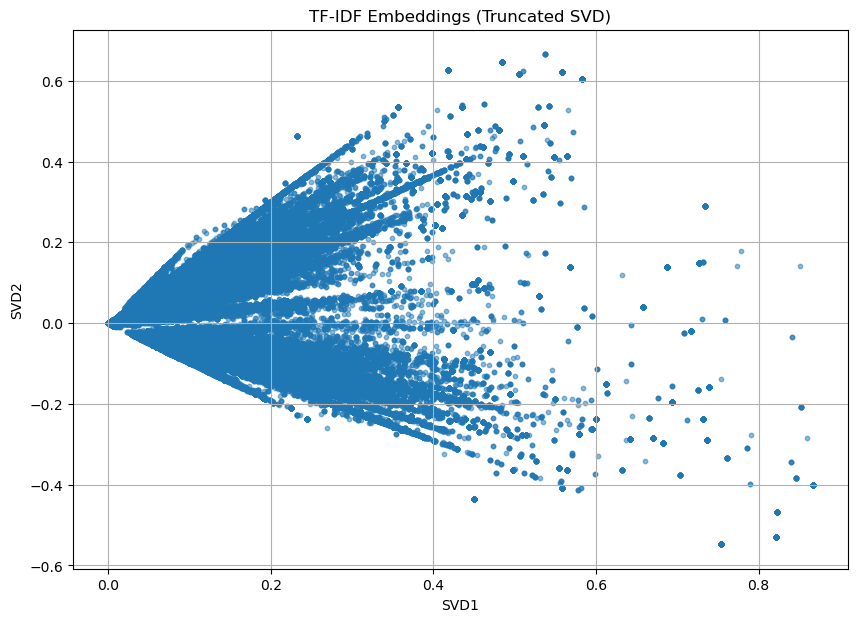

In [105]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

plt.figure(figsize=(10, 7))
plt.scatter(X_svd[:, 0], X_svd[:, 1], alpha=0.5, s=10)
plt.title("TF-IDF Embeddings (Truncated SVD)")
plt.xlabel("SVD1")
plt.ylabel("SVD2")
plt.grid(True)
plt.show()


#### 3.4 clusterization
Will use hdbscan since

In [ ]:
!pip install hdbscan



In [ ]:
data_combined.shape

In [110]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=300, metric='euclidean')
cluster_labels = clusterer.fit_predict(X_tfidf)
print("Number of clusters:", len(np.unique(cluster_labels)))

KeyboardInterrupt: 

In [109]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3, metric='cosine', linkage='average')
labels = model.fit_predict(X_tfidf.toarray())

data_combined['cluster'] = labels

MemoryError: Unable to allocate 26.7 GiB for an array with shape (717268, 5000) and data type float64

#### 3.2 plan b

Цель:

Сгруппировать вакансии с похожими названиями (на русском и английском, с разным порядком слов) и для каждой группы собрать топ-скиллов.
1. Предобработка текста вакансий и скиллов

    Очистка и нормализация текста:

        Привести к нижнему регистру (lowercase).

        Убрать пунктуацию и спецсимволы.

        Убрать лишние пробелы.

        Заменить числа на пустоту или единый токен.

        Заменить синонимы и вариации вручную (например, “разработчик python” = “python разработчик” = “python developer”).

    Почему?
    Убираем шум и стандартизируем, чтобы простые текстовые сравнения были эффективнее.

2. Представление вакансий числовыми векторами (эмбеддингами)

    Использовать предобученные языковые модели с мультилингвальной поддержкой:

        Multilingual Sentence Transformers (например, sentence-transformers/paraphrase-multilingual-MiniLM) — создают вектор для каждого текста (названия вакансии).

        Или простые TF-IDF векторы для быстрой проверки (хотя хуже по смыслу).

    Почему?
    Чтобы понять не просто точное совпадение текста, а смысловую близость, даже если порядок слов разный или часть слов отличается.

3. Кластеризация вакансий по смыслу

    Применить кластеризацию к эмбеддингам вакансий:

        Алгоритмы: DBSCAN, HDBSCAN (не требует заранее задавать число кластеров, умеет выделять шум).

        Или Agglomerative Clustering с порогом расстояния.

    Почему?
    Чтобы автоматически сгруппировать похожие вакансии вместе (например, все варианты "python developer" в один кластер).

4. Обработка скиллов в каждой группе

    Для каждой группы вакансий собрать все скиллы из вакансий этого кластера.

    Подсчитать частоту каждого скилла.

    Отсортировать по убыванию и выбрать топ N (например, топ 10).

    Можно применить ту же очистку скиллов, как в пункте 1 (привести к нижнему регистру, убрать лишние символы).

5. Проверка и корректировка результатов

    Проанализировать образовавшиеся кластеры.

    При необходимости вручную добавить синонимы в словарь для замены.

    Проверить топ-скиллы — убрать слишком общие, нерелевантные.

Итог:
Вакансия (кластер)	Топ-скиллы
python developer / питон разработчик	python, django, sql, git, ...
data analyst / аналитик данных	sql, tableau, excel, power bi
Инструменты:

    Python: pandas, numpy

    Очистка текста: re, str.lower(), словари для замены

    Векторизация: sentence-transformers, scikit-learn (TF-IDF)

    Кластеризация: hdbscan, sklearn.cluster

    Подсчёт частот: collections.Counter или pandas.Series.value_counts()



In [29]:
# todo: plan b :)